Tutorial: Calculating Spectra
=================
This is an example how to calculate spectra from pyGDM simulations.

We start again by loading the pyGDM modules that we are going to use:

In [1]:
## --- Load the pyGDM modules 
from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import linear
from pyGDM2 import visu
from pyGDM2 import tools

## --- we will use numpy as well
import numpy as np

Setting up the simulation
----------------------------

In [2]:
## --- we will use again sphere of R=60nm, this time made of gold
## --- for demonstration purpose we will discretize rather coarse
step = 20
geometry = structures.sphere(step, R=3, mesh='cube')
norm = structures.get_normalization(mesh='cube')
material = materials.gold()
n1 = n2 = 1.0

struct = structures.struct(step, geometry, material, n1,n2, norm)


## --- we use again a plane wave
field_generator = fields.planewave
## --- this time however, we want to calculate a whole spectrum.
## --- we use numpy's *linspace* to get a list of linearly 
## --- spaced wavelengths
wavelengths = np.linspace(400, 1000, 30)
## --- let's furthermore simulate three linear polarizations
kwargs = dict(theta=[0, 45, 90], kSign=[-1])

efield = fields.efield(field_generator, 
               wavelengths=wavelengths, kwargs=kwargs)


## --- define the numerical experiment
sim = core.simulation(struct, efield)

Run the simulation
--------------------

**Note:** The output of *scatter* can be turned off by passing "verbose=False"

In [3]:
## --- run the simulation
E = core.scatter(sim)

timing for wl=400.00nm - setup: 31.3 ms, inv.: 99.8 ms, repropa.: 1.5ms (3 field configs), tot: 133.2 ms
timing for wl=420.69nm - setup: 30.0 ms, inv.: 72.9 ms, repropa.: 1.5ms (3 field configs), tot: 105.9 ms
timing for wl=441.38nm - setup: 54.6 ms, inv.: 72.0 ms, repropa.: 1.5ms (3 field configs), tot: 128.7 ms
timing for wl=462.07nm - setup: 29.2 ms, inv.: 91.8 ms, repropa.: 1.5ms (3 field configs), tot: 123.1 ms
timing for wl=482.76nm - setup: 37.0 ms, inv.: 102.1 ms, repropa.: 1.5ms (3 field configs), tot: 141.4 ms
timing for wl=503.45nm - setup: 29.5 ms, inv.: 84.9 ms, repropa.: 1.5ms (3 field configs), tot: 116.6 ms
timing for wl=524.14nm - setup: 29.5 ms, inv.: 106.8 ms, repropa.: 1.6ms (3 field configs), tot: 138.1 ms
timing for wl=544.83nm - setup: 29.9 ms, inv.: 99.4 ms, repropa.: 1.6ms (3 field configs), tot: 131.0 ms
timing for wl=565.52nm - setup: 38.7 ms, inv.: 70.4 ms, repropa.: 1.6ms (3 field configs), tot: 110.9 ms
timing for wl=586.21nm - setup: 30.0 ms, inv.: 106.7 

Short comment: Structure of the simulation results
-----------------------------------------------------

**E**, as well as the *simulation* instance (**sim.E**) now contain the self-consistent electric field inside the nano-particle for each incident field configuration.
**sim.E** is a list of lists. Each element of **sim.E** contains as first entry the simulation configuration encoded as a dictionary with keys cooresponding to the parameters taken by the field-generator (in our case this was **fields.planewave**). 
The second entry is a list of complex 3-tuples (Ex, Ey, Ez), corresponding to the complex electric field at the according meshpoint (defined by **sim.structure.geometry**).

Let's have a look:

In [4]:
print("fieldindex '0' :", sim.E[0][0])
print("fieldindex '1' :", sim.E[1][0])
print("fieldindex '17':", sim.E[17][0])
print("Shape of field :", sim.E[17][1].shape)
print("     (--> (Number of meshopint, E(XYZ)) )")

fieldindex '0' : {'kSign': -1, 'theta': 0, 'wavelength': 400.0}
fieldindex '1' : {'kSign': -1, 'theta': 45, 'wavelength': 400.0}
fieldindex '17': {'kSign': -1, 'theta': 90, 'wavelength': 503.44827}
Shape of field : (147, 3)
     (--> (Number of meshopint, E(XYZ)) )


If we search a particular field-configuration, the fieldindex notation is probably not very intuitive since it is a sequentiel number, specifying one within all possible permutations of field-parameters.

To find the closest available configuration for specific search-values, one can use:

In [5]:
search_dict = dict(theta=80, kSign=-1, wavelength=750)
idx = tools.get_closest_field_index(sim, search_dict)

print('closest match: index', idx)
print('    --> dict:', sim.E[idx][0])

closest match: index 53
    --> dict: {'kSign': -1, 'theta': 90, 'wavelength': 751.7241}


Evaluating the simulation
-----------------------------

The field inside the particle might be interesting to know, but since it is  hardly accessible in experiment, usually more easily accessible physical quantities are derived from the internal fields.

Let's calculate the extinction, scattering and absorption corss-section for the above field configuration:

**Note:** all high-level evaluation function like provided by the *linear* module take (at least) the *simulation* object and a fieldindex as first two parameters.

In [6]:
a_ext, a_scat, a_abs = linear.extinct(sim, idx)
print("cross sections:")
print("    extinction = {:.2f} nm^2".format(float(a_ext)))
print("    scattering = {:.2f} nm^2".format(float(a_scat)))
print("    absorption = {:.2f} nm^2".format(float(a_abs)))

cross sections:
    extinction = 11328.24 nm^2
    scattering = 6050.29 nm^2
    absorption = 5277.94 nm^2


/home/hans/.local/lib/python3.7/site-packages/pyGDM2-1.1rc1-py3.7-linux-x86_64.egg/pyGDM2/linear.py:105: UserWarning: Info: The fortran code underlying 'extinct' will be replaced by a python/numpy implementation in one of the next releases. The new implementation can be tested by using the `linear_py` instead of the `linear` module.
  "The new implementation can be tested by using the `linear_py` " +


Calculating a spectrum
-----------------------------

To calculate a full spectrum of some physical quantity like the above corss sections, we now simply need to evaluate all the fields composing a spectrum.
Because again, it is not evident, which fieldindices correspond to a spectrum for, let's say, *X*-polarization (theta=0), there are helper-functions for spectrum-calculation, provided by pyGDM:

In [7]:
## get all simulated configurations, each corresponding to a spectrum
field_kwargs = tools.get_possible_field_params_spectra(sim)
for i, conf in enumerate(field_kwargs):
    print("config", i, ":", conf)

config 0 : {'kSign': -1, 'theta': 0}
config 1 : {'kSign': -1, 'theta': 45}
config 2 : {'kSign': -1, 'theta': 90}


Now let's calculate and plot cross-sections for the spectrum "config 0":

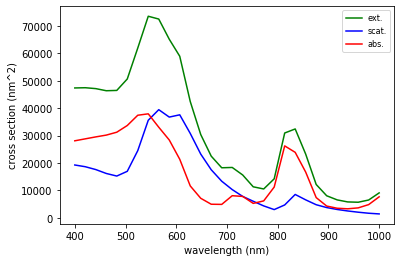

In [8]:
## --- calculate a spectrum using a specific evaluation function.
## --- We will use the spectrum with theta=0 on "linear.extinct":
config_idx = 0
wl, spectrum = tools.calculate_spectrum(sim, 
                    field_kwargs[config_idx], linear.extinct)

## --- linear.extinct returns 3-tuples, "spectrum" therefore consists
## --- of an array of 3-tuples, corresponding to extinction, 
## --- scattering and absorption.

import matplotlib.pyplot as plt

plt.plot(wl, spectrum.T[0], 'g-', label='ext.')
plt.plot(wl, spectrum.T[1], 'b-', label='scat.')
plt.plot(wl, spectrum.T[2], 'r-', label='abs.')

plt.xlabel("wavelength (nm)")
plt.ylabel("cross section (nm^2)")
plt.legend(loc='best', fontsize=8)

plt.show()

We can use any of the other evaluation functions to calculate a spectrum:

In [9]:
## --- total deposited heat in particle
wl, spec_heat = tools.calculate_spectrum(sim, 
          field_kwargs[config_idx], linear.heat)


## --- temperature increase at [0,0,200] (nm)
wl, spec_temp = tools.calculate_spectrum(sim, 
          field_kwargs[config_idx], linear.temperature, r_probe=[0,0,200])


## --- nearfield at [0,0,200] (nm)
wl, spec_nf = tools.calculate_spectrum(sim, 
          field_kwargs[config_idx], linear.nearfield, r_probe=[0,0,200])
## --- calculate the nearfield intensity (Ex**2 + Ey**2 + Ez**2)
## indices [0][1] denote: 
##         - [0] first of one evaluated positions
##         - [1] total Efield (E0 + Escat)
spec_nf_intensity = (np.abs(spec_nf.T[3])**2 + 
                     np.abs(spec_nf.T[4])**2 + 
                     np.abs(spec_nf.T[5])**2)[0][1]

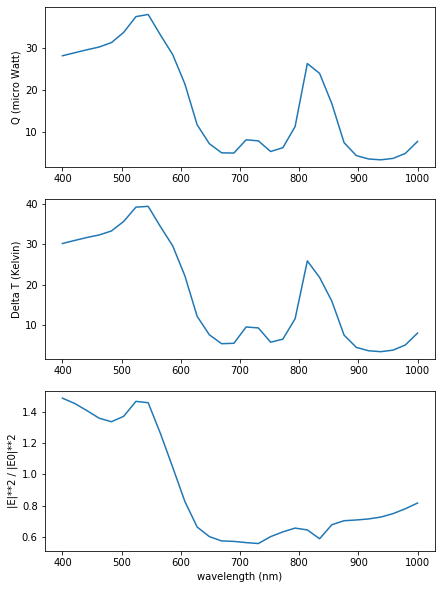

In [10]:
## --- plot the spectra
plt.figure(figsize=(7,10))
plt.subplot(311)
plt.plot(wl, spec_heat/1E3)
plt.ylabel("Q (micro Watt)")

plt.subplot(312)
plt.plot(wl, spec_temp)
plt.ylabel("Delta T (Kelvin)")

plt.subplot(313)
plt.plot(wl, spec_nf_intensity)
plt.xlabel("wavelength (nm)")
plt.ylabel("|E|**2 / |E0|**2")

plt.show()

Finally, let's compare the three different polarizations we simulated. Since we calculated a sphere in vaccum, they should result in an identical response. 

Let's check the scattering spectra:

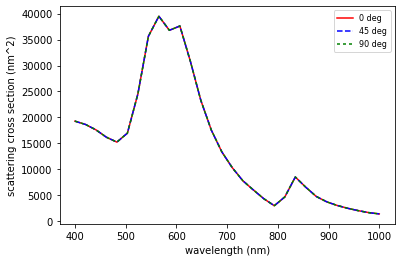

In [11]:
wl, spec0 = tools.calculate_spectrum(sim, 
                    field_kwargs[0], linear.extinct)
wl, spec45 = tools.calculate_spectrum(sim, 
                    field_kwargs[1], linear.extinct)
wl, spec90 = tools.calculate_spectrum(sim, 
                    field_kwargs[2], linear.extinct)


import matplotlib.pyplot as plt

plt.plot(wl, spec0.T[1], 'r-', label='0 deg')
plt.plot(wl, spec45.T[1], 'b--', label='45 deg')
plt.plot(wl, spec45.T[1], 'g', dashes=[2,2], label='90 deg')

plt.xlabel("wavelength (nm)")
plt.ylabel("scattering cross section (nm^2)")
plt.legend(loc='best', fontsize=8)

plt.show()

Looks as if the curves were overlapping!

Simulation with polarization dependent response
-----------------------------------

Finally, let's try what happens if we use a non-symmetric structure which should have an optical response that varies with the incident polarization angle.

In [12]:
## --- rectangular wire with otherwise same configuration as above
geometry = structures.rect_wire(step, L=20, W=4, H=3)
struct = structures.struct(step, geometry, material, n1,n2, norm)

## --- same spectrum as above but with a lot more polarization angles
kwargs = dict(theta=np.linspace(0, 90, 31), kSign=[-1])
efield = fields.efield(field_generator, 
               wavelengths=wavelengths, kwargs=kwargs)

## --- define the numerical experiment
sim_polarizations = core.simulation(struct, efield)

## --- run the simulation
E = core.scatter(sim_polarizations)

timing for wl=400.00nm - setup: 49.6 ms, inv.: 156.3 ms, repropa.: 28.0ms (31 field configs), tot: 234.5 ms
timing for wl=420.69nm - setup: 59.4 ms, inv.: 147.9 ms, repropa.: 28.3ms (31 field configs), tot: 236.2 ms
timing for wl=441.38nm - setup: 56.1 ms, inv.: 94.8 ms, repropa.: 27.7ms (31 field configs), tot: 179.2 ms
timing for wl=462.07nm - setup: 52.4 ms, inv.: 113.8 ms, repropa.: 26.3ms (31 field configs), tot: 192.8 ms
timing for wl=482.76nm - setup: 49.9 ms, inv.: 111.1 ms, repropa.: 26.5ms (31 field configs), tot: 187.7 ms
timing for wl=503.45nm - setup: 51.1 ms, inv.: 160.3 ms, repropa.: 26.6ms (31 field configs), tot: 238.3 ms
timing for wl=524.14nm - setup: 51.0 ms, inv.: 156.6 ms, repropa.: 26.3ms (31 field configs), tot: 234.5 ms
timing for wl=544.83nm - setup: 49.5 ms, inv.: 118.3 ms, repropa.: 30.9ms (31 field configs), tot: 198.9 ms
timing for wl=565.52nm - setup: 50.1 ms, inv.: 143.0 ms, repropa.: 26.8ms (31 field configs), tot: 220.1 ms
timing for wl=586.21nm - setu

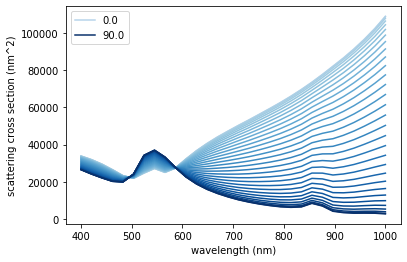

In [13]:
## --- get the spectra-configurations
spectra_kwargs = tools.get_possible_field_params_spectra(sim_polarizations)

## --- plot scattering for all configs (--> diff. polarizations)
colors = plt.cm.Blues(np.linspace(0.3, 1.0, len(spectra_kwargs)))
for i, field_kwargs in enumerate(spectra_kwargs):
    wl, spec0 = tools.calculate_spectrum(sim_polarizations, i, linear.extinct)

    lab = ''
    if i in [0, len(spectra_kwargs)/2, len(spectra_kwargs)-1]:
        lab = field_kwargs['theta']
    plt.plot(wl, spec0.T[1], color=colors[i], label=lab)

plt.legend(loc='best')
plt.xlabel("wavelength (nm)")
plt.ylabel("scattering cross section (nm^2)")

plt.show()

The different shades of blue indicate the different incident linear polarizations from light blue (zero degrees, parallel to the rod) to dark blue (90 degrees, perpendicular to the rod)